# Dispersion Relation

Text retrieved from [1]: _"The electrostatic waves propagating inside the plasma are expected to obey a particular dispersion relation, i.e. for a given angular wavenumber $k$ only a certain wave angular frequency $\omega$ is allowed. The ratio between the two quantities defines the wave phase velocity $v_{ph} = \omega/k$. For electrostatic waves, also known as Langmuir waves, the dispersion relation is given by_ [2]:

\begin{equation}
    1 = \frac{\omega_p^2}{k^2} \int^\infty_{-\infty} \frac{\partial \hat{f}_0/\partial v}{v - (\omega/k)} dv
\label{eq:dispersion_relation}
\end{equation}

_where $\hat{f}_0$ corresponds to the distribution function in velocity space. The solution will have both a real and imaginary part. The real part corresponds to the wave angular frequency, while the imaginary part corresponds to the inverse of the wave damping time (a phenomenon known as Landau damping)._"

#### References
[1] D. Carvalho et al., arXiv:2310.17646 (2023) - See Section 6.4 <br>
[2] F. Chen, Introduction to Plasma Physics and Controlled Fusion Vol. 1 (1984) - See Chapter 7 <br>


In [1]:
import os
import sys
import jax
import pickle
import numpy as np

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib.pyplot as plt
import matplotlib.colors as pcolors

sys.path.append('../..')
from sheet_model.utils import get_dx_eq, get_x_eq, get_Efield_vectorized, get_roots_dispersion_relation
from gns.simulator import SMGNS

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

### Initial Conditions

In [2]:
# system properties
n_sheets = 10000 # larger values allow for higher FFT resolution (but increase significantly memory req. + run-time)
boundary = 'periodic'

# aux variables
x_eq = get_x_eq(n_sheets)
dx_eq = get_dx_eq(n_sheets)

# initial velocity distribution std 
# ! it is not v_th, part of the energy will be deposited in the fields
v_std_0 = 5.2 # [dx_eq w_p]

# for reproducibility
np.random.seed(42)

# intial x/v values
x_0 = np.copy(x_eq)
v_0 = np.random.normal(0, v_std_0, n_sheets) * dx_eq

# sim params
t_max = 2000
t_chunck = 200 # sub-divide into smaller chuncks to avoid using too much GPU memory
dt_undersample = 1

### Initialize GNS

In [3]:
gns = SMGNS('../../models/final/dt1e-1/4', boundary)

Simulator Info
   GNN model: ../../models/final/dt1e-1/4
   boundary: periodic
   L: 1
   dt_train: 0.1
   Training Dataset
      L: 1.0
      augment_t: True
      augment_x: True
      boundary: periodic
      data_folder: data/dataset/train/10/periodic/
      dt_simulator: 0.01
      dt_undersample: 10
      mode: crossings
      n_neighbors: 1
      n_sheets: 10
      save_folder: data/processed_temp/train/dt1e-1
      var_target: dvdt
      w_size: 1


### Run Simulation

In [4]:
X = []
V = []
E = []

x_0c = x_0.copy()
v_0c = v_0.copy()
x_eqc = x_eq.copy()

for t in np.arange(0, t_max, t_chunck):
    
    print(f't: {t} - {t + t_chunck}')
    Xc, Vc, Xeqc , Ec = gns.pred_rollout(x_0c,
                                         v_0c,
                                         x_eqc,
                                         t_max=t_chunck,
                                         verbose=True,
                                         track_sheets=False,
                                         n_guards=0,
                                         dt_undersample=dt_undersample,
                                         np_=np)
    
    X.append(Xc[:-1])
    V.append(Vc[:-1])
    E.append(Ec[:-1])
    
    i_sort = np.argsort(Xc[-1])
    
    x_0c = Xc[-1].copy()[i_sort]
    v_0c = Vc[-1].copy()[i_sort]
    x_eqc = Xeqc[-1].copy()[i_sort]
  

X = np.concatenate(X, axis=0)
V = np.concatenate(V, axis=0)
E = np.concatenate(E, axis=0)

print('dE/E0:', (E[-1]-E[0])/E[0])

t: 0 - 200


  0%|          | 0/2000 [00:00<?, ?it/s]

t: 200 - 400


  0%|          | 0/2000 [00:00<?, ?it/s]

t: 400 - 600


  0%|          | 0/2000 [00:00<?, ?it/s]

t: 600 - 800


  0%|          | 0/2000 [00:00<?, ?it/s]

t: 800 - 1000


  0%|          | 0/2000 [00:00<?, ?it/s]

t: 1000 - 1200


  0%|          | 0/2000 [00:00<?, ?it/s]

t: 1200 - 1400


  0%|          | 0/2000 [00:00<?, ?it/s]

t: 1400 - 1600


  0%|          | 0/2000 [00:00<?, ?it/s]

t: 1600 - 1800


  0%|          | 0/2000 [00:00<?, ?it/s]

t: 1800 - 2000


  0%|          | 0/2000 [00:00<?, ?it/s]

dE/E0: 0.010594597


### Compute Correct $\lambda_D$ and $v_{max}$ (maximum sheet velocity)

In [5]:
# lambda_d == v_th in our units
# use last step to compute
lambda_d = np.std(V[-1] / dx_eq) # [dx_eq]
k_d = 2 * np.pi / lambda_d # [dx_eq^-1]
v_max = np.max(V) / dx_eq # [dx_eq w_p]
print(f'lambda_d: {lambda_d:.2f}')
print(f'v_max: {v_max:.2f}')

lambda_d: 5.01
v_max: 27.41


In [6]:
# 99.95% quantile
np.quantile(np.abs(V), 0.9995) / dx_eq / lambda_d # [v_th]

3.4682659088292564

### (Optional) Store / Load Outputs

**Note**: This will cost ~1.5GB for the original setup parameters 

In [7]:
with open(f'dispersion_relation.pkl', 'wb') as f:
    results = {
        'x': X, # needed for E-field
        'lambda_d': lambda_d, # needed for langmuir curve + x-axis
        'v_max': v_max, # needed for ballistic modes curve
    }
    pickle.dump(results, f)

In [8]:
with open(f'dispersion_relation.pkl', 'rb') as f:
    results = pickle.load(f)
    X = results['x'].copy()
    lambda_d = results['lambda_d']
    v_max = results['v_max']
    del results

### Compute Electric Field ($w,k$) Spectrum

In [9]:
nx = n_sheets # e-field resolution [number of points along x]
nt = len(X) # time resolution [number of points along y]
Ef = get_Efield_vectorized(x=X[:nt], nx = nx+1, dx_eq=dx_eq)[-1] # e-field (nt, nx)

In [10]:
# compute power spectrum (k, w)
kw_Ef = np.abs(np.fft.fft2(Ef[:nt]))**2
kw_Ef = np.fft.fftshift(kw_Ef)
# remove DC
kw_Ef[:, kw_Ef.shape[1]//2] = 1e-12
# keep only w >= 0 & k >= 0 (rest is duplicated)
kw_Ef = kw_Ef[nt//2:,nx//2:]
# spectrum range
k_max = np.pi * nx / n_sheets # [dx_eq^-1]
w_max = np.pi / (dt_undersample * gns.dt_train)  # [w_p]

### Plot Dispersion Relation

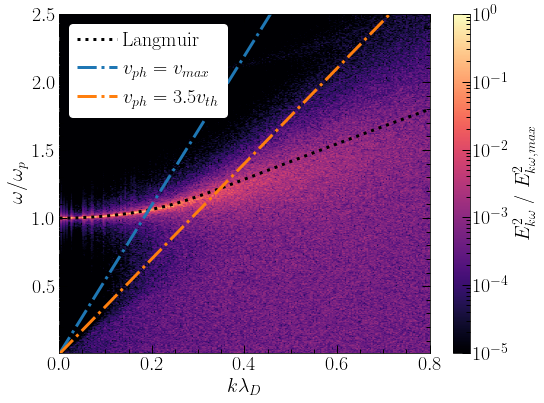

In [11]:
plt.figure(figsize=(8,6))

# power spectrum
plt.imshow(kw_Ef/np.max(kw_Ef), 
           origin='lower', 
           norm=pcolors.LogNorm(vmin = 1e-5, vmax = 1e0),
           extent=(0, k_max * lambda_d, 0, w_max), 
           aspect='auto', 
           cmap='magma'
          )

# langmuir theoretical values
k = np.logspace(-3, 0.5, 100)
w = [np.real(get_roots_dispersion_relation(x)[0]) for x in k]
plt.plot(k, w, label = "Langmuir", color='black', ls=':', lw=3)

# ballistic modes limits
plt.plot(k, v_max/lambda_d * k, label='$v_{ph} = v_{max}$', ls='-.', lw=3)
plt.plot(k, 3.5 * k, label='$v_{ph} = 3.5v_{th}$', ls='-.', lw=3)

plt.xlabel("$k\lambda_D$")
plt.ylabel("$\omega/\omega_p$")
plt.xlim(0, 0.8)
plt.ylim(0.01, 2.5)
plt.legend(loc='upper left', framealpha=1., fancybox=True)
plt.colorbar(label='$E_{k\omega}^2$ / $E_{k\omega,max}^2$')

plt.tight_layout()
plt.savefig(f'../img/dispersion_relation.pdf', dpi=300)
plt.show()